# SCC-DFTB repulsive potential generation (2-body)

bla bla bla

![image](logo.png)


In [1]:

import os
import sys
import warnings


base_dir=os.getcwd()
os.chdir(base_dir)
print('You are here:', base_dir)

warnings.filterwarnings('ignore')
sys.path.append('../pgm/CCS/')
print(sys.path)

import json
import itertools as it
from collections import OrderedDict, defaultdict
import numpy as np
from ase import Atoms
from ase import io
from ase.calculators.neighborlist import NeighborList
import ase.db as db
import sys
from ccs.common.exceptions import ScriptError 
from ccs.fitting.main import twp_fit
from ccs.ase_tools.ccs_ase_calculator import CCS




You are here: /home/broqvist/Desktop/parautomatik/Electrolyte
['/home/broqvist/Desktop/parautomatik/Electrolyte', '', '/home/broqvist/Desktop/parautomatik/pgm/skprogs/opt/lib/python3.9/site-packages', '/home/broqvist/PGM/python', '/home/broqvist/PGM/python/jasp_master', '/home/broqvist/PGM/python/cheetah3-master', '/home/broqvist/PGM/rdkit-Release_2016_03_1', '/home/broqvist/Desktop/parautomatik/Electrolyte', '/home/broqvist/PGM/pytgit/MacroDensity', '/home/broqvist/PROJECTS/DFTB-Electroyte-wf/SK/test/hotbit_install/lib/python', '/home/broqvist/Desktop/parautomatik/pgm/CCS', '/home/broqvist/miniconda3/envs/parautomatik/lib/python39.zip', '/home/broqvist/miniconda3/envs/parautomatik/lib/python3.9', '/home/broqvist/miniconda3/envs/parautomatik/lib/python3.9/lib-dynload', '/home/broqvist/miniconda3/envs/parautomatik/lib/python3.9/site-packages', '/home/broqvist/miniconda3/envs/parautomatik/lib/python3.9/site-packages/IPython/extensions', '/home/broqvist/.ipython', '../pgm/CCS/']


In [2]:
def pair_dist(atoms, R_c, ch1, ch2):
    ''' This function returns pairwise distances between two types of atoms within a certain cuttoff
    Args:
        R_c (float): Cut off distance(6. Å)
        ch1 (str): Atom species 1
        ch2 (str): Atoms species 2

    Returns:
        A list of distances in bohr
    '''
    if ch1 == ch2:

        nl = NeighborList(atoms.get_number_of_atoms() *
                          [R_c], self_interaction=False, bothways=False)
    else:
        nl = NeighborList(atoms.get_number_of_atoms() *
                          [R_c], self_interaction=False, bothways=True)

    nl.update(atoms)
    distances = []
    for j in range(atoms.get_number_of_atoms()):
        if (atoms.get_chemical_symbols()[j] == ch1):
            indices, offsets = nl.get_neighbors(j)
            for i, offset in zip(indices, offsets):
                if(atoms.get_chemical_symbols()[i] == ch2):
                    distances.append((np.linalg.norm(
                        atoms.positions[i] + np.dot(offset, atoms.get_cell()) - atoms.positions[j])))

    distances.sort()
    r_distances = [round(elem, 6)
                   for elem in distances]
    return r_distances


def generate_data(DFT_DB, DFTB_DB, R_c=5.0):
    """  Function to read files and output structures.json
    
    Args:
        args(list): list of filenames
        R_c (float, optional): Distance cut-off. Defaults to 5.0.
    """
    cwd = os.getcwd()
    if not os.path.isdir(cwd+"/CCS/"):
        os.mkdir(cwd+"/CCS/")

    os.chdir(cwd+"/CCS/")



    species = []
    counter=0
    c = OrderedDict()
    d = OrderedDict()
    for row in DFTB_DB.select():
        FDFTB=row.forces
        EDFTB=row.energy
        key=str(row.key)
        struct=row.toatoms()
        EDFT=DFT_DB.get('key='+key).energy
        FDFT=DFT_DB.get('key='+key).forces	
        counter = counter +1
        print("Reading configuration: "+ str(counter))
        c = OrderedDict()
        dict_species = defaultdict(int)
        for elem in struct.get_chemical_symbols():
            dict_species[elem] += 1
        atom_pair = it.combinations_with_replacement(dict_species.keys(), 2)
        c['energy_dft'] = EDFT
        c['energy_dftb'] = EDFTB
        c['elec'] = EDFTB
        c['atoms'] = dict_species
        for (x, y) in atom_pair:
            pair_distances = pair_dist(struct, R_c, x, y)
            c[str(x)+'-'+str(y)] = pair_distances
        d['S'+str(counter+1)] = c
    with open('structures.json', 'w') as f:
        json.dump(d, f, indent=8)
    os.chdir(cwd) 
    
def generate_ccsdb(DFTB_data,eps, rc): 
    cwd = os.getcwd()
    os.chdir(cwd+"/CCS/")
    from ccs.calculator.ccs import CCS
    import ase.db as db
    calc = CCS(charge=False,eps=eps,rcut=rc)

    DFTB_DB=db.connect(DFTB_data)
    CCS_DB=db.connect('CCS_DB.db')
    for row in DFTB_DB.select():
        structure=row.toatoms()
        structure.calc=calc
        structure.get_potential_energy()
        CCS_DB.write(structure, key=row.key)
    os.chdir(cwd)

def write_input(input):
    cwd = os.getcwd()
    os.chdir(cwd+"/CCS/")
    out_file = open("input.json", "w")  
    json.dump(input, out_file) 
    out_file.close()
    os.chdir(cwd)
    
def fit_ccs(args):
    cwd = os.getcwd()
    os.chdir(cwd+"/CCS/")
#    logging.info('Started')
    print(args.input,  os.getcwd() )
    twp_fit(args.input)
#    logging.info('Ended') 
    os.chdir(cwd)  

In [ ]:
#generate data (once, takes time) generates structures.json
os.chdir(base_dir)
!pwd
DFTB_DB=db.connect("DFTB_DB.db")   
DFT_DB=db.connect("DFT_DB.db")   
generate_data(DFT_DB,DFTB_DB)

In [15]:
#input for fitting data in json format
elements  = 'C,H,O,Li' # ["C", "H", "Li", "O"]

input = {
"Twobody":{
	"H-H":{
		"Rcut":8.0,
		"Nknots":200,
                "Swtype":"rep"
	}, 
        "C-C":{
                "Rcut":8.0,
                "Rmin":1.0,
                "Nknots":200,
                "Swtype":"rep"
        },
        "O-O":{
                "Rcut":8.0,
                "Rmin":1.0, 
                "Nknots":200,
                "Swtype":"rep"
        },
        "C-H":{
                "Rcut":8.0,
                "Rmin":1.0,
                "Nknots":200,
                "Swtype":"rep"
        },
        "O-H":{
                "Rcut":8.0,
                "Rmin":1.0,
                "Nknots":200,
                "Swtype":"rep"
        },
        "C-O":{
                "Rcut":8.0,
                "Rmin":1.0,
                "Nknots":200,
                "Swtype":"rep"
        },
        "Li-H":{
                "Rcut":8.0,
                "Rmin":1.0,
                "Nknots":200,
                "Swtype":"rep"
        },
 
        "Li-C":{
                "Rcut":8.0,
                "Rmin":1.0, 
                "Nknots":200,
                "Swtype":"rep"
        },
        "Li-O":{
                "Rcut":8.0,
                "Rmin":1.0, 
                "Nknots":200,
                "Swtype":"rep"
        }
},

"Onebody":["H", "C", "Li", "O"],

"Reference":"structures.json",

"General":{
	"interface":"DFTB+",
	"ctype":"mono",
        "smooth":"True"
}

}

write_input(input)

/home/broqvist/Desktop/parautomatik/Electrolyte
input.json /home/broqvist/Desktop/parautomatik/Electrolyte/CCS
There is linear dependence in stochiometry matrix!
    removing onebody term: C
There is linear dependence in stochiometry matrix!
    removing onebody term: Li
There is linear dependence in stochiometry matrix!
    removing onebody term: O
Exponentail head -> 'headfit.dat'
Repulsive in Spline format -> 'H-H.spl'
Exponentail head -> 'headfit.dat'
Repulsive in Spline format -> 'C-C.spl'
Exponentail head -> 'headfit.dat'
Repulsive in Spline format -> 'O-O.spl'
Exponentail head -> 'headfit.dat'
Repulsive in Spline format -> 'C-H.spl'
Exponentail head -> 'headfit.dat'
Repulsive in Spline format -> 'O-H.spl'
Exponentail head -> 'headfit.dat'
Repulsive in Spline format -> 'C-O.spl'
Exponentail head -> 'headfit.dat'
Repulsive in Spline format -> 'Li-H.spl'
Exponentail head -> 'headfit.dat'
Repulsive in Spline format -> 'Li-C.spl'
Exponentail head -> 'headfit.dat'
Repulsive in Spline 

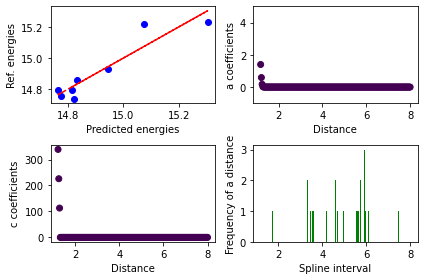

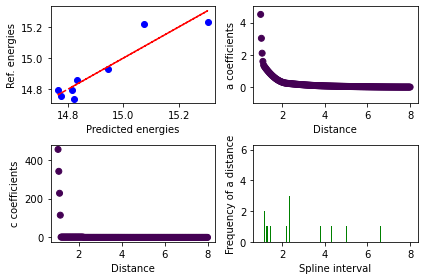

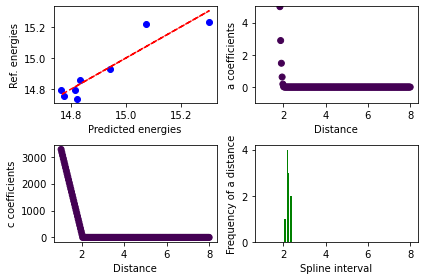

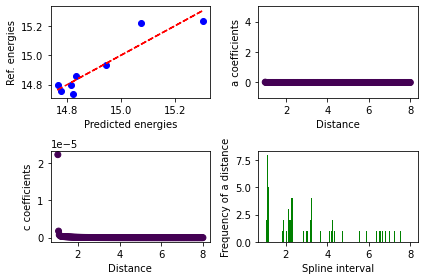

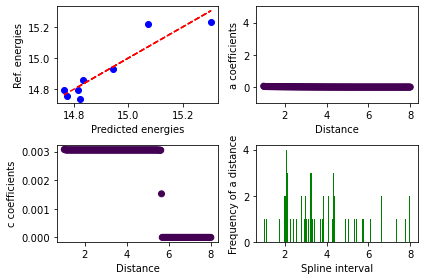

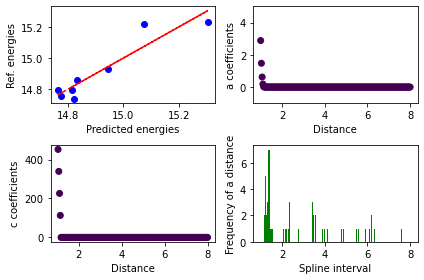

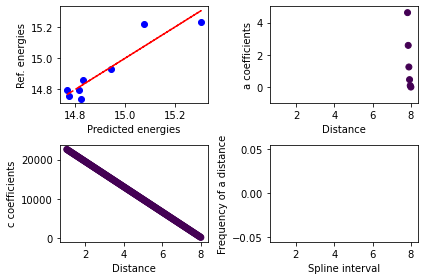

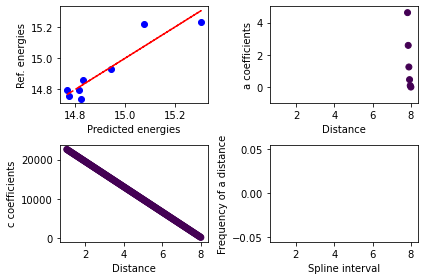

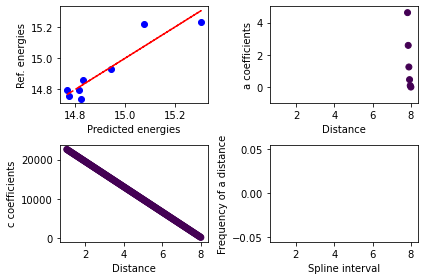

In [16]:
os.chdir(base_dir)
!pwd

class Args:
    cmdlineargs=None
    input = 'input.json'

args=Args()
fit_ccs(args)
#!pwd

In [17]:
struct=db.connect("DFT_DB.db")
db_ccs=db.connect("CCS_DB.db")
with open('./CCS/CCS_params.json', 'r') as f:
    CCS_params = json.load(f)

for row in struct.select(): 
    structure=row.toatoms()
    structure.calc=CCS(CCS_params=CCS_params)
    structure.get_potential_energy()
    structure.get_forces()
    db_ccs.write(structure,key=row.key,CCS=True)

In [8]:
!pwd

/home/broqvist/Desktop/parautomatik/Electrolyte
